# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [2]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [3]:
!pip install torchinfo

In [4]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [12]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

Визуализируйте несколько картинок с соответствующими метками из датасета.

In [13]:
len(train_dataset), len(val_dataset)

(60000, 10000)

Размер картинки:torch.Size([1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

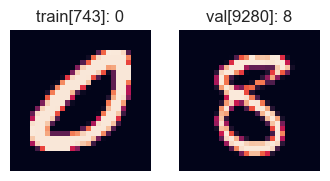

In [14]:
# берем 2 рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off")

Создайте генераторы батчей.

In [15]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [16]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "red"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

Для начала возьмем модель как была в ноутбуке с семинара

In [77]:
cnn1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
summary(cnn1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

Вторую модель сделаем с одним сверточным слоем и одним линейным слоем

In [78]:
cnn2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=5408, out_features=10),
).to(device)
summary(cnn2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Flatten: 1-4                           [1, 5408]                 --
├─Linear: 1-5                            [1, 10]                   54,090
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
Total mult-adds (M): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.22
Estimated Total Size (MB): 0.39

В третью модель добавим 3 сверточных слоя и также попробуем добавить в них padding.Линейный слой будет 1.

In [79]:
cnn3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=128, out_features=10),
).to(device)
summary(cnn3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 128, 3, 3]            73,856
├─MaxPool2d: 1-8                         [1, 128, 1, 1]            --
├─ReLU: 1-9                              [1, 128, 1, 1]            --
├─Flatten: 1-10                          [1, 128]                  --
├─Linear: 1-11                           [1, 10]                   1,290
Total params: 93,962
Trainable params: 93,962
Non-trainable params: 0
Tot

В четвертой модели сделаем 3 сверточных и два линейных слоя. Также во второй и третий слой добавим padding

In [80]:
cnn4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
summary(cnn4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 13, 13]           18,496
├─MaxPool2d: 1-5                         [1, 64, 6, 6]             --
├─ReLU: 1-6                              [1, 64, 6, 6]             --
├─Conv2d: 1-7                            [1, 128, 6, 6]            73,856
├─MaxPool2d: 1-8                         [1, 128, 3, 3]            --
├─ReLU: 1-9                              [1, 128, 3, 3]            --
├─Flatten: 1-10                          [1, 1152]                 --
├─Linear: 1-11                           [1, 256]                  295,168
├─ReLU: 1-12                             [1, 256]                  --
├

В пятую модель добавим 4 сверточных слоя и 2 линейных.

In [81]:
cnn5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4608, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
).to(device)
summary(cnn5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 128, 13, 13]          36,992
├─MaxPool2d: 1-5                         [1, 128, 6, 6]            --
├─ReLU: 1-6                              [1, 128, 6, 6]            --
├─Conv2d: 1-7                            [1, 256, 8, 8]            295,168
├─MaxPool2d: 1-8                         [1, 256, 4, 4]            --
├─ReLU: 1-9                              [1, 256, 4, 4]            --
├─Conv2d: 1-10                           [1, 512, 6, 6]            1,180,160
├─MaxPool2d: 1-11                        [1, 512, 3, 3]            --
├─ReLU: 1-12                             [1, 512, 3, 3]            -

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn1.parameters())
history_cnn1 = train(
    cnn1,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn1.state_dict(), "cnn1.pth")

Epoch 20 of 20 took 7.328 s
  training loss: 	0.002515
  validation loss: 	0.037074
  training accuracy: 			99.94 %
  validation accuracy: 			99.21 %


In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2.parameters())
history_cnn2 = train(
    cnn2,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn2.state_dict(), "cnn2.pth")

Epoch 20 of 20 took 7.170 s
  training loss: 	0.005525
  validation loss: 	0.068099
  training accuracy: 			99.89 %
  validation accuracy: 			98.31 %


In [84]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn3.parameters())
history_cnn3 = train(
    cnn3,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn3.state_dict(), "cnn3.pth")

Epoch 20 of 20 took 7.182 s
  training loss: 	0.005399
  validation loss: 	0.088368
  training accuracy: 			99.80 %
  validation accuracy: 			98.32 %


In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn4.parameters())
history_cnn4 = train(
    cnn4,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn4.state_dict(), "cnn4.pth")

Epoch 20 of 20 took 7.653 s
  training loss: 	0.003166
  validation loss: 	0.035724
  training accuracy: 			99.90 %
  validation accuracy: 			99.36 %


In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn5.parameters())
history_cnn5 = train(
    cnn5,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn5.state_dict(), "cnn5.pth")

Epoch 20 of 20 took 8.416 s
  training loss: 	0.007565
  validation loss: 	0.043557
  training accuracy: 			99.82 %
  validation accuracy: 			99.22 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

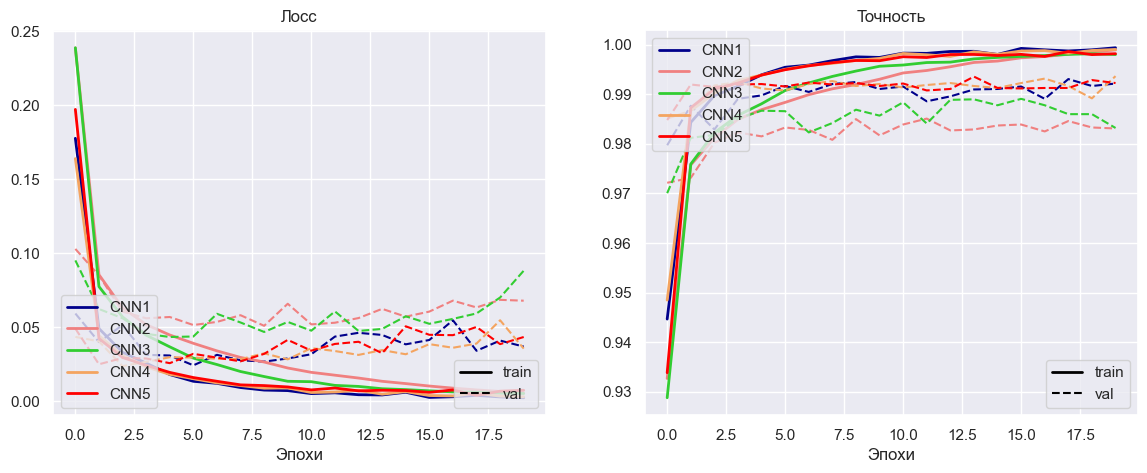

In [87]:
plot_histories([history_cnn1, history_cnn2, history_cnn3, history_cnn4, history_cnn5], ["CNN1", "CNN2", "CNN3", "CNN4","CNN5"])

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:**

По экспериминту видно, что если слоев слишком мало(например 1 линейный и 1 сверточный), то модель справляется хуже, также если слоев слишком много как например в 5 модели, то она справляется хуже чем если взять 3 сверточных и 2 линейных или 2 сверточных и 2 линейных как в моделях 1 и 4. Также можно понять, что чем больше слоев тем больше время обучения.  

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

В прошлом эксперименте лучшая модель получилась четвертая. Так что для этого эксперимента будем использовать 3 сверточных и 2 линейных слоя.

Первую модель возьмем такую же как четвертую из предыдущего эксперимента.

In [6]:
cnn2_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
summary(cnn2_1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 13, 13]           18,496
├─MaxPool2d: 1-5                         [1, 64, 6, 6]             --
├─ReLU: 1-6                              [1, 64, 6, 6]             --
├─Conv2d: 1-7                            [1, 128, 6, 6]            73,856
├─MaxPool2d: 1-8                         [1, 128, 3, 3]            --
├─ReLU: 1-9                              [1, 128, 3, 3]            --
├─Flatten: 1-10                          [1, 1152]                 --
├─Linear: 1-11                           [1, 256]                  295,168
├─ReLU: 1-12                             [1, 256]                  --
├

Теперь попробуем взять размер ядра 2.

In [7]:
cnn2_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
summary(cnn2_2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 27, 27]           160
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 12, 12]           8,256
├─MaxPool2d: 1-5                         [1, 64, 6, 6]             --
├─ReLU: 1-6                              [1, 64, 6, 6]             --
├─Conv2d: 1-7                            [1, 128, 7, 7]            32,896
├─MaxPool2d: 1-8                         [1, 128, 3, 3]            --
├─ReLU: 1-9                              [1, 128, 3, 3]            --
├─Flatten: 1-10                          [1, 1152]                 --
├─Linear: 1-11                           [1, 256]                  295,168
├─ReLU: 1-12                             [1, 256]                  --
├─

Также попробуем в разном порядке брать ядра 3x3 4x4 5x5.

In [8]:
cnn2_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1152, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)
summary(cnn2_3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 12, 12]           32,832
├─MaxPool2d: 1-5                         [1, 64, 6, 6]             --
├─ReLU: 1-6                              [1, 64, 6, 6]             --
├─Conv2d: 1-7                            [1, 128, 6, 6]            204,928
├─MaxPool2d: 1-8                         [1, 128, 3, 3]            --
├─ReLU: 1-9                              [1, 128, 3, 3]            --
├─Flatten: 1-10                          [1, 1152]                 --
├─Linear: 1-11                           [1, 256]                  295,168
├─ReLU: 1-12                             [1, 256]                  --


Попробуем также изменить количество фильтров на слоях.

In [10]:
cnn2_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=9216, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
).to(device)
summary(cnn2_4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 26, 26]           640
├─MaxPool2d: 1-2                         [1, 64, 13, 13]           --
├─ReLU: 1-3                              [1, 64, 13, 13]           --
├─Conv2d: 1-4                            [1, 256, 13, 13]          147,712
├─MaxPool2d: 1-5                         [1, 256, 6, 6]            --
├─ReLU: 1-6                              [1, 256, 6, 6]            --
├─Conv2d: 1-7                            [1, 1024, 6, 6]           2,360,320
├─MaxPool2d: 1-8                         [1, 1024, 3, 3]           --
├─ReLU: 1-9                              [1, 1024, 3, 3]           --
├─Flatten: 1-10                          [1, 9216]                 --
├─Linear: 1-11                           [1, 512]                  4,719,104
├─ReLU: 1-12                             [1, 512]                

In [28]:
cnn2_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=5, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=1024, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),
).to(device)
summary(cnn2_5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 26, 26]           640
├─MaxPool2d: 1-2                         [1, 64, 13, 13]           --
├─ReLU: 1-3                              [1, 64, 13, 13]           --
├─Conv2d: 1-4                            [1, 256, 11, 11]          409,856
├─MaxPool2d: 1-5                         [1, 256, 5, 5]            --
├─ReLU: 1-6                              [1, 256, 5, 5]            --
├─Conv2d: 1-7                            [1, 1024, 5, 5]           2,360,320
├─MaxPool2d: 1-8                         [1, 1024, 2, 2]           --
├─ReLU: 1-9                              [1, 1024, 2, 2]           --
├─Flatten: 1-10                          [1, 4096]                 --
├─Linear: 1-11                           [1, 512]                  2,097,664
├─ReLU: 1-12                             [1, 512]                

Обучим первую модель:

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2_1.parameters())
history_cnn2_1 = train(
    cnn2_1,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn2_1.state_dict(), "cnn2_1.pth")

Epoch 20 of 20 took 7.323 s
  training loss: 	0.004345
  validation loss: 	0.036035
  training accuracy: 			99.89 %
  validation accuracy: 			99.27 %


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2_2.parameters())
history_cnn2_2 = train(
    cnn2_2,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn2_2.state_dict(), "cnn2_2.pth")

Epoch 20 of 20 took 7.345 s
  training loss: 	0.004594
  validation loss: 	0.045992
  training accuracy: 			99.84 %
  validation accuracy: 			99.00 %


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2_3.parameters())
history_cnn2_3 = train(
    cnn2_3,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn2_3.state_dict(), "cnn2_3.pth")

Epoch 20 of 20 took 7.167 s
  training loss: 	0.003300
  validation loss: 	0.040845
  training accuracy: 			99.91 %
  validation accuracy: 			99.27 %


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2_4.parameters())
history_cnn2_4 = train(
    cnn2_4,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn2_4.state_dict(), "cnn2_4.pth")

Epoch 20 of 20 took 10.457 s
  training loss: 	0.003584
  validation loss: 	0.041668
  training accuracy: 			99.91 %
  validation accuracy: 			99.18 %


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2_5.parameters())
history_cnn2_5 = train(
    cnn2_5,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)
torch.save(cnn2_5.state_dict(), "cnn2_5.pth")

Epoch 20 of 20 took 10.327 s
  training loss: 	0.004116
  validation loss: 	0.040857
  training accuracy: 			99.90 %
  validation accuracy: 			99.32 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

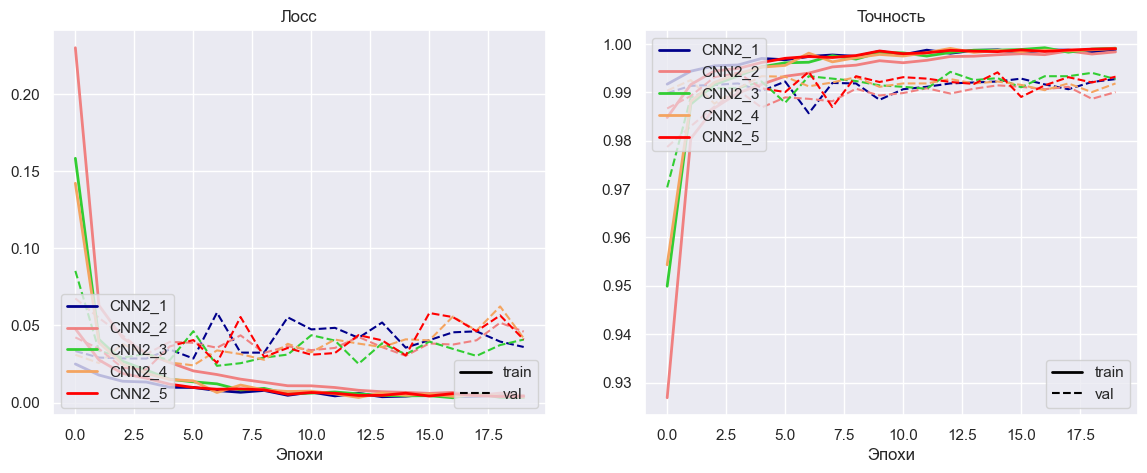

In [32]:
plot_histories([history_cnn2_1, history_cnn2_2, history_cnn2_3, history_cnn2_4, history_cnn2_5], ["CNN2_1", "CNN2_2", "CNN2_3", "CNN2_4","CNN2_5"])

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:**

Видно, что при маленьком размере ядра(2) точность падает с 99,3 до 99 процентов, также как и при большом размере ядер точность тоже падает по сравнению с размером 3. Однако если варьировать ядро например как в 5 модели поставить размеры 3 5 3, то точность повышается. Также видно, что время обучения в основном зависит не от размера ядер, а от количества параметров. При слишком большом количестве параметров например как в 4 модели точность также падает, из-за возможного переобучения.

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

In [39]:
model = cnn2_5

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

Заведем 3 массива: неправильные ответы нейросети, количество правильных ответов для данной цифры и количество всего данных цифр в датасете:

In [52]:
incorrect_examples = []
correct_predictions = np.array([0] * 10)
number_predictions = np.array([0] * 10)

Сделаем проходы по train_dataset и val_dataset обновляя наши массивы:

In [53]:
def CheckPredictions(dataset):
    for i in dataset:
        image, label = i
        number_predictions[label] += 1

        with torch.no_grad():
            logits = model(image.to(device).unsqueeze(0))[0].cpu()

        probs = torch.softmax(logits, dim=0)
        predicted = torch.argmax(probs).item()
        if (label != predicted):
            incorrect_examples.append([image, label, predicted])
        else:
            correct_predictions[label] += 1
CheckPredictions(train_dataset)
CheckPredictions(val_dataset)


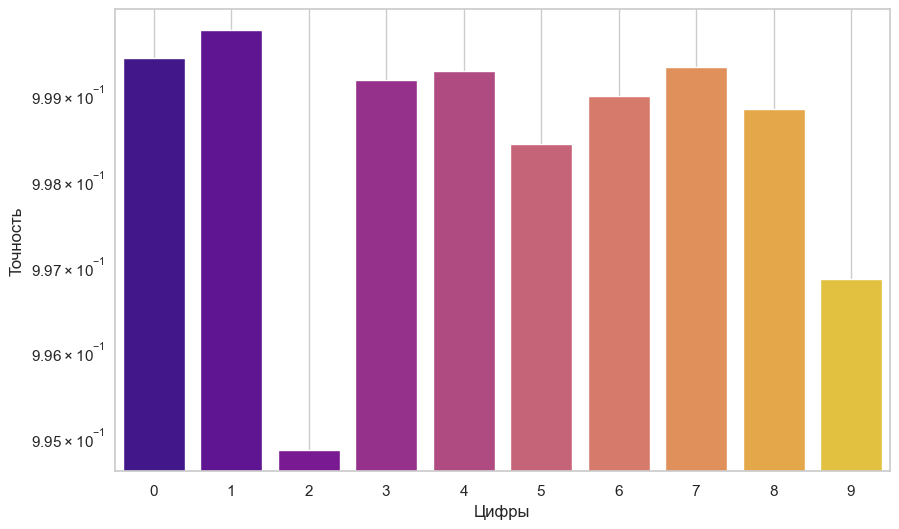

In [68]:

with sns.axes_style("whitegrid"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=range(10), y=correct_predictions / number_predictions, palette="plasma")
        
    plt.xlabel('Цифры')
    plt.ylabel('Точность')
        
    plt.yscale('log')
    plt.grid(True) 

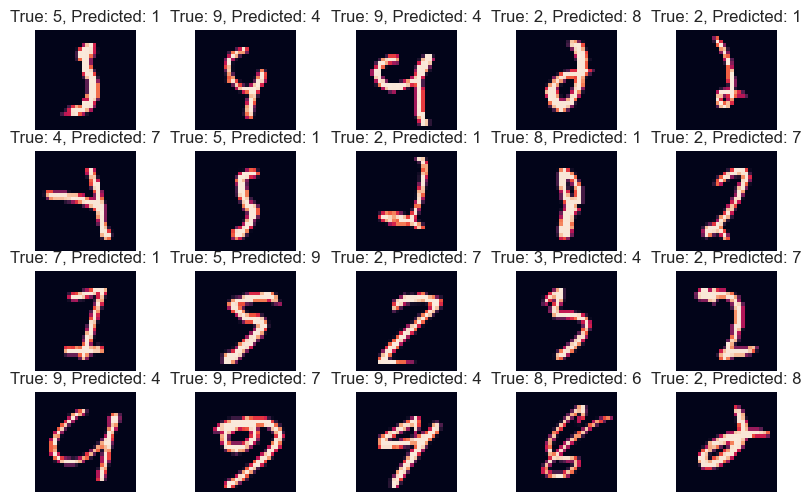

In [67]:
plt.figure(figsize=(10,6))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(incorrect_examples[i][0].permute(1, 2, 0))
    plt.title(f'True: {incorrect_examples[i][1]}, Predicted: {incorrect_examples[i][2]}')
    plt.axis('off')
    

**Ответ:** 

По примерам видно, что нейросеть не справляется с похожими цифрами например 4 и 9, 2 и 7. Она в основном не справляется если цифра нарисована не понятно(например у 2 снизу маленький хвостик).

**Вывод по всей задаче:** 

Мы написали нейросеть которая распознает цифры на картинке. Путем подбора числа слоев и размера ядра мы смогли получить довольно точную модель(99,32% точность). Однако если смотреть на график цифр, то можно понять, что у нейросети есть некоторые проблемы с цифрами похожими друг на друга, из-за того что эти цифры написаны не понятно(особенно с 2, она постоянно путает ее с 7 или 1).

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

**Вывод:**
<...>